# 加载库

In [16]:
import os
os.chdir("/path/to/workdir")
from utils import read_pkl
import pandas as pd 
import seaborn as sns
from matplotlib.colors import to_rgba
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from colormaps import cmaps
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 15
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300 


## load data

In [8]:
import gc
import numpy as np
import scipy.stats as ss
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer
def compute_entropy(distribution):
    non_zero_values = np.array([v for v in distribution.values() if v > 0])
    if len(non_zero_values) == 0:
        return 0
    return -np.sum(non_zero_values * np.log(non_zero_values))

def compute_surprisal(distribution, encoded):
    eps = 1e-7 
    if encoded[0] not in distribution or distribution[encoded[0]] == 0:
        return -np.log(eps)
    return -np.log(distribution[encoded[0]])

import scipy.stats as ss
import numpy as np
def distribution_union(dist1, dist2):
    union_keys = set(dist1.keys()).union(set(dist2.keys()))
    lst1 = np.array([dist1.get(key, 0) for key in union_keys])
    lst2 = np.array([dist2.get(key, 0) for key in union_keys])
    return lst1, lst2

def js_divergence(info_dist, shuffled_dist):
    lst1, lst2 = distribution_union(info_dist, shuffled_dist)
    M = (lst1 + lst2) / 2
    return 0.5 * ss.entropy(lst1, M) + 0.5 * ss.entropy(lst2, M)

def kl_divergence(info_dist, shuffled_dist, epsilon=1e-12):
    lst1, lst2 = distribution_union(info_dist, shuffled_dist)

    lst1 = lst1 + epsilon
    lst2 = lst2 + epsilon

    lst1 /= lst1.sum()
    lst2 /= lst2.sum()

    kl_div = ss.entropy(lst1, lst2)

    return kl_div / np.log(2)

n_context = 100
window_lst = list(range(1, 21))
model_name = 'gpt'
condition = 'exp1'
if model_name == 'gpt':
    tokenizer = AutoTokenizer.from_pretrained('/data/model/pretrain/gpt2')
elif model_name == 'qwen':
    tokenizer = AutoTokenizer.from_pretrained("/data/model/pretrain/Qwen2.5-1.5B")

existing_files = {}
existing_files[condition] = []
for n_window in window_lst:
    path = f"data/{condition}-context-{n_context}/{model_name}-window-{n_window}.pkl"
    if os.path.exists(path):
        existing_files[condition].append(n_window)

print(f"processing {condition} ...")
across_window = []
for n_window in tqdm(existing_files[condition]):
    # [results, article list]
    # article list: 1000 × n_band × [context, [window, predicted words], sentences]
    # results: 10 runs × 1000 articles × 2 conditions × n_band × 5 steps × [predict word, distribution]
    path = f"data/{condition}-context-{n_context}/{model_name}-window-{n_window}.pkl"
    if not os.path.exists(path):
        break
    result = read_pkl(path)
    art_lst = result[1]
    result = result[0]
    across_seed = []
    
    tok_lst = []
    for art in art_lst:
        a = art[0]
        target_word = a[1][1].split(' ')[0]
        assert target_word.isalpha(), f"{target_word}"
        assert a[1][0][-1] != ' ', f"whitespace in {a[1][0]}"
        encoded = tokenizer(' ' + target_word, add_special_tokens=False).input_ids
        tok_lst.append(encoded)
        
    for seed_lst in result:
        across_item = []
        for lst, encoded, art in zip(seed_lst, tok_lst, art_lst):
            origin_lst = lst[0]
            shuffled_lst = lst[1]
            baseline_lst = lst[2]
            white_lst = lst[3]
            across_band = []
            for s_lst, b_lst, w_lst, a in zip(shuffled_lst, baseline_lst, white_lst, art):
                n_band = len(a[1][0].split(' ')) 
                o = origin_lst[0]
                s = s_lst[0]
                b = b_lst[0]
                w = w_lst[0]
                s_js = js_divergence(o[1], s[1])
                b_js = js_divergence(o[1], b[1])
                w_js = js_divergence(o[1], w[1])
                across_band.append([[0, s_js, b_js, w_js], n_band])

            across_item.append(across_band)
        across_seed.append(across_item)
    across_window.append(across_seed)
    del result
    del across_seed
    del across_item
    gc.collect()

processing exp1 ...


0it [00:00, ?it/s]


## compute JS

In [ ]:
import numpy as np
import scipy.stats as ss
from tqdm import tqdm
from collections import defaultdict
from transformers import AutoTokenizer

n_context = 100

df = defaultdict(list)
for n_window, across_seed in tqdm((zip(window_lst, across_window)), total=len(across_window)):
    for seed, across_item in enumerate(across_seed):
        for across_band in across_item:
            for item in across_band:
                # a: [context, [window, predicted words], sentences]
                js_lst, n_band  = item

                df['n_window'].extend([n_window] * 4)
                df['model_name'].extend([model_name] *4)
                df['condition'].extend([condition] * 4)
                df['n_band'].extend([n_band] * 4)
                
                df['js'].extend(js_lst)
                df['input_type'].extend(['origin', 'shuffle', 'baseline', 'whiteboard'])
from utils import save_pkl,read_pkl
save_pkl(f"plot/data/{condition}_{model_name}.pkl", df)

100%|██████████| 20/20 [00:00<00:00, 37.16it/s]


## plot

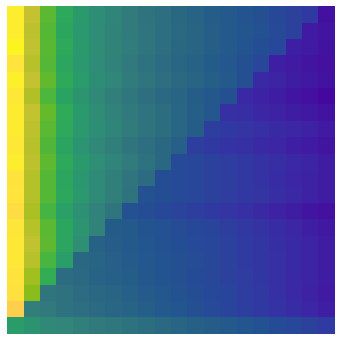

In [9]:
df = read_pkl("plot/data/exp1_gpt.pkl")
plt.rcParams['font.size'] = 15

df = pd.DataFrame.from_dict(df)
data = df[df['model_name'] == model_name]
plot_data = [[] for _ in range(1, 21)]
metrics = 'js'

for n_window in range(1, 21):
    window_data = data[data['n_window'] == n_window]
    
    for n_band in range(1, 21):
            
        band_data = window_data[window_data['n_band'] == n_band]
        band_data = band_data[band_data['input_type'] == 'shuffle']
        tmp = band_data[metrics].values.tolist()

        band_data = window_data[window_data['n_band'] == n_band + 1]
        band_data = band_data[band_data['input_type'] == 'shuffle']
        tmp1 = band_data[metrics].values.tolist()
        plot_data[n_window-1].append(np.mean(tmp))

fig, ax = plt.subplots(1, 1,figsize=(5,5))
mask = np.ones_like(plot_data, dtype=bool)
np.fill_diagonal(mask, False)
mask = ~mask
sns.heatmap(plot_data, annot=False, cbar=False, xticklabels=False, yticklabels=False, linewidths=0, ax=ax, cmap=cmaps['parula'])
cbar = ax.collections[0].colorbar

plt.gca().invert_yaxis()
plt.tight_layout()



## compute strength of boundary effect

In [13]:
def add_seed_column(df):
    df['seed'] = 0

    for n_window in df['n_window'].unique():
        data = df[df['n_window'] == n_window].copy()
        n_row = len(data)
        n_item = int(len(data) / (20*4*10))
        n_split = n_item * 20 *4 
        for seed, seed_start in enumerate(range(0, n_row, n_split)):
            data.iloc[seed_start:seed_start+n_split, data.columns.get_loc('seed')] = seed
        df.loc[df['n_window'] == n_window, 'seed'] = data['seed']
    
    return df
tmp_lst = []
data_lst = [['exp1_gpt', 'exp1_gpt_zh'],]
for d in data_lst:
    df = read_pkl(f"plot/data/{d[0]}.pkl")
    df_zh = read_pkl(f"plot/data/{d[1]}.pkl")
    df = add_seed_column(pd.DataFrame.from_dict(df))
    df_zh = add_seed_column(pd.DataFrame.from_dict(df_zh))

    lst = []
    for df_tmp in [df, df_zh]:
        data = df_tmp[df_tmp['model_name'].isin(['qwen', 'gpt'])]
        for input_type in ['shuffle', 'baseline', 'whiteboard']:
            seed_lst = []
            for seed in range(10):
                seed_data = data[data['seed'] == seed]
                plot_data = [[] for _ in range(1, 21)]
                metrics = 'js'
                for n_window in range(1, 21):
                    window_data = seed_data[seed_data['n_window'] == n_window]
                    for n_band in range(1, 21):
                        band_data = window_data[window_data['n_band'] == n_band]
                        band_data = band_data[band_data['input_type'] == input_type]
                        tmp = band_data[metrics].values.tolist()
                        if pd.isna(np.mean(tmp)):
                            print(seed, n_window, n_band, tmp)
                        plot_data[n_window-1].append(np.mean(tmp))
                
                tmp = np.array(plot_data).transpose()
                tmp = np.flip(tmp, 0)
                seed_lst.append(tmp)
            lst.append(seed_lst)
    tmp_lst.append(lst)

In [14]:
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from scipy import stats


def linear(X, b1, b2, c):
    x1, x2 = X
    return c + b1*x1 + b2*x2

def exp(X, b1, b2, c):
    x1, x2 = X
    return c + np.exp(-b1*(x1)) + np.exp(-b2*(x2)) 

def power(X, b1, b2, c):
    x1, x2 = X
    return c + x1**(-b1) + x2**(-b2)
        
def regression(matrix, func_name):
    ma = max(matrix.flatten())
    mi = min(matrix.flatten())
    data = []
    for j in range(20):
        for i in range(19, -1, -1):
            window_length = 20 - i
            distance = j + 1
            data.append([window_length, distance, (matrix[i, j])/(ma)])
    
    regress_data = pd.DataFrame(data, columns=["Row", "Col", "Value"])
    x1, x2 = [regress_data["Row"], regress_data["Col"]]
    y = regress_data["Value"]
    if func_name == 'linear':
        model_func = linear
    elif func_name == 'exp':
        model_func = exp
    elif func_name == 'power':
        model_func = power
    popt, pcov = curve_fit(model_func, (x1, x2), y, p0=(0,0,0))
    y_pred = model_func((x1, x2), *popt)

    # r square
    residuals = y - y_pred
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    
    residuals = np.array(residuals).reshape((20,20))
    
    residuals = np.flip(residuals, axis=0)

    y_pred = np.array(y_pred).reshape((20, 20))
    y_pred = np.flip(y_pred, axis=0)
    return residuals, y_pred, r_squared

total_effect = []
for lst, d in zip(tmp_lst, data_lst):
    effect = []
    for l_idx, lang in enumerate(['en', 'zh']):
        for c_idx, c in enumerate(['shuffle', 'baseline', 'whiteboard']):
            seed_lst = lst[l_idx * 3 + c_idx]
            seed_ef = []
            for matrix in seed_lst:
                info = []
                for func_name in ['power']:
                    residuals, y_pred, r_squared = regression(matrix, func_name)
                    info.append([residuals, y_pred, r_squared])
                info = sorted(info, key = lambda x: x[-1], reverse=True)
                residuals = info[0][0]
                ef_lst = []
                for i in range(19, -1, -1):
                    before_bound = []
                    after_bound = []
                    for j in range(20):
                        window_length = j
                        distance = 20-i-1
                        js = residuals[i, j] 
                        if distance > window_length:
                            before_bound.append(js)
                        elif distance < window_length:
                            after_bound.append(js)
                        
                    if not before_bound or not after_bound:
                        continue
                    ef_lst.append(before_bound[-1] - after_bound[0])
                seed_ef.append(np.mean(ef_lst))
            effect.append(seed_ef)
    total_effect.append(effect)

## plot

[3 3]


/tmp/ipykernel_836563/1873748844.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  g = sns.barplot(data = df_r, x='lang', y='diff', hue ='type', ax=ax,
/tmp/ipykernel_836563/1873748844.py:21: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': 'k'}` instead.

  g = sns.barplot(data = df_r, x='lang', y='diff', hue ='type', ax=ax,
/tmp/ipykernel_836563/1873748844.py:21: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.5}` instead.

  g = sns.barplot(data = df_r, x='lang', y='diff', hue ='type', ax=ax,
/tmp/ipykernel_836563/1873748844.py:50: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  g = sns.stripplot(


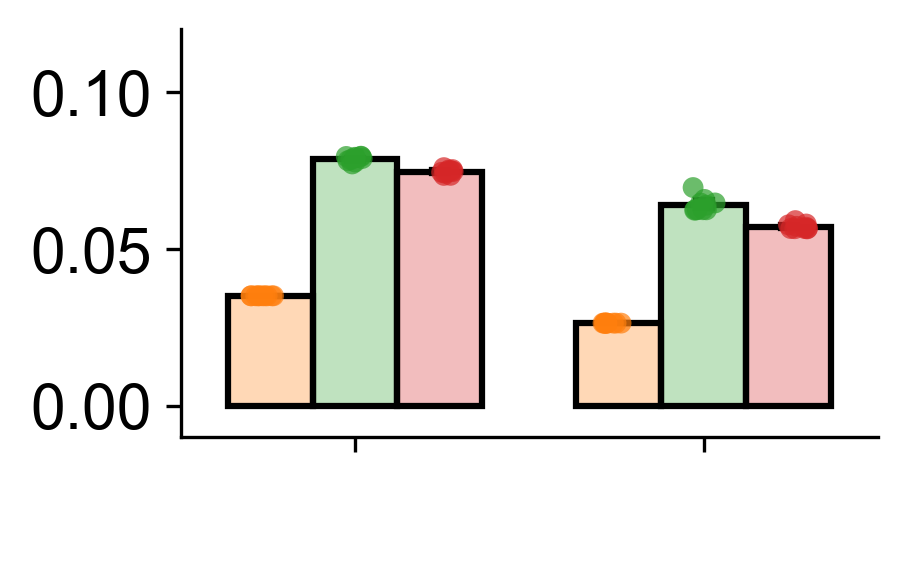

In [17]:

sns.set_context(rc = {'patch.linewidth': 1.5})
fig, ax = plt.subplots(1, 1 , figsize=(3,1.8))

palette = {
    'shuffle': 'grey',
    'baseline': 'grey',
    'whiteboard': 'grey',
}

df_r = {'diff':[], 'type':[], 'lang':[]}
for l_idx, lang in enumerate(['en', 'zh']):
    for t_idx, input_type in enumerate(['shuffle', 'baseline', 'whiteboard']):
        info_idx = l_idx * 3 + t_idx
        for seed in range(10):
            item = total_effect[0][info_idx][seed]
            df_r['diff'].append(item)
            df_r['type'].append(input_type)
            df_r['lang'].append(lang)

df_r = pd.DataFrame.from_dict(df_r)
g = sns.barplot(data = df_r, x='lang', y='diff', hue ='type', ax=ax, 
                palette=palette,
                errorbar = ('ci', 95),  
                estimator=np.mean, ci=95, capsize=.14, 
                errwidth=1.5, errcolor = 'k', 
                edgecolor =  (0,0,0,1), width=0.73,
                hue_order = ['whiteboard', 'shuffle', 'baseline', ]
                )
hue_nums = df_r.groupby("lang")["type"].nunique().values
print(hue_nums)

color_lst = [
    'grey',
    
    'grey',
    'grey',]

palette = sns.color_palette()[1:]
color_lst = palette
for i, bar in enumerate(g.patches):
    if i == sum(hue_nums):
        break
    x_category = np.repeat(np.arange(max(hue_nums)), len(hue_nums))[i]
    hue_category = np.tile(np.arange(max(hue_nums)), len(hue_nums))[i]
    color = color_lst[x_category]
    bar.set_facecolor(to_rgba(color, 0.3))
    bar.set_edgecolor((0, 0, 0, 1))
    

g = sns.stripplot(
    data = df_r,
    x="lang", 
    y="diff", 
    hue="type", 
    dodge=True, 
    alpha=0.7,
    edgecolor=None, 
    palette=palette,
    ax=ax,
    hue_order = ['whiteboard', 'shuffle', 'baseline', ]

)

sns.despine(top=True, right=True, left=False, bottom=False)
g.set(ylabel='')
g.set(xlabel='  ')

g.set(ylim=[-0.01,0.12])


g.set(yticks=[0, 0.05, 0.1])
g.set(ylabel='  ')
g.set(xlabel='  ')
g.set(xticklabels=[])

plt.ylabel("")
plt.xlabel(r"   ")

plt.legend([],[], frameon=False)
